!pip install lightgbm

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('/Users/..../../anomaly_detection/archive/cpu-full-a.csv', parse_dates=[0], infer_datetime_format=True)
df2 = pd.read_csv('/Users/..../../anomaly_detection/archive/cpu-full-b.csv', parse_dates=[0], infer_datetime_format=True)

In [3]:
df2.shape

(660, 2)

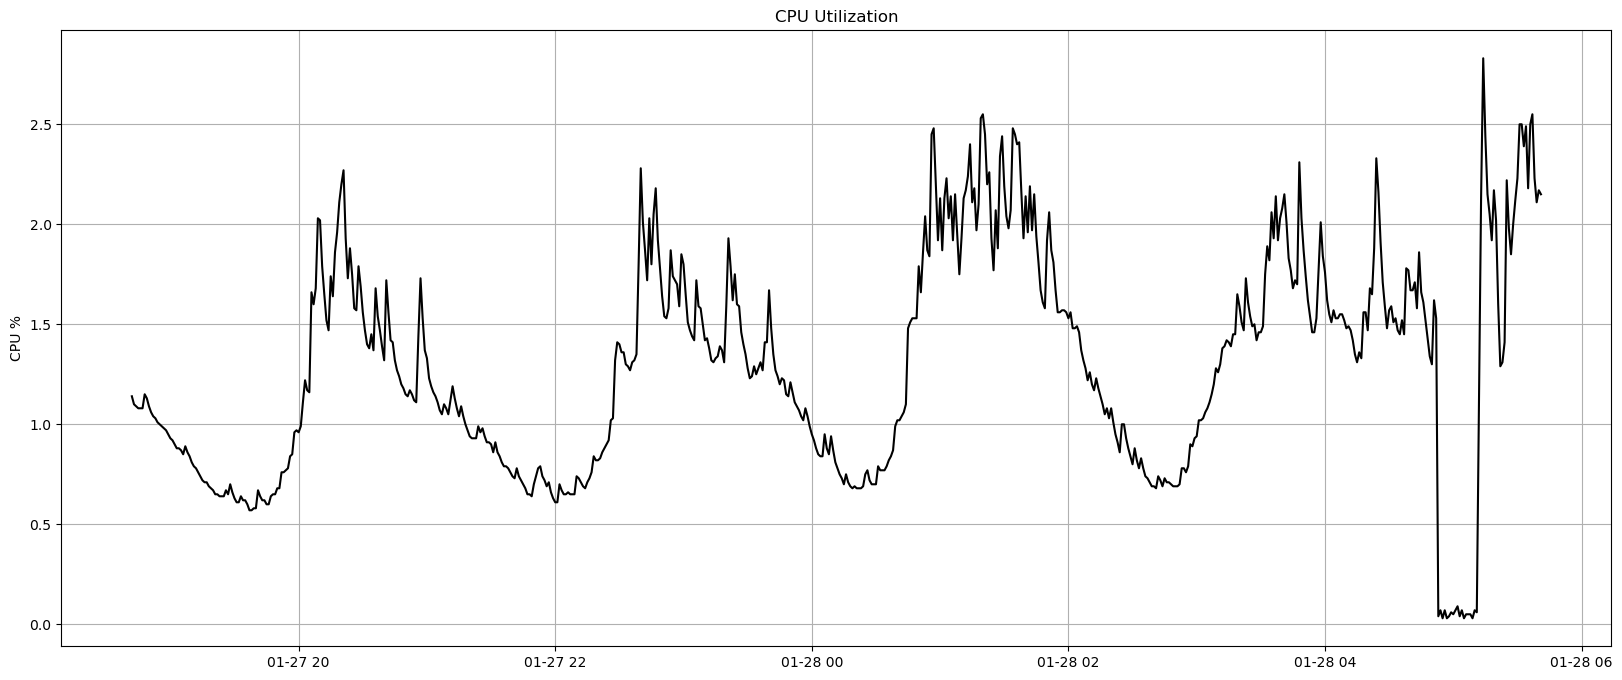

In [4]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,8))
plt.plot(df2['datetime'], df2['cpu'], color='black')
plt.ylabel('CPU %')
plt.grid()
plt.title('CPU Utilization')
plt.show()

In [5]:
#Normalizing the data before passing it into the xgbmodel
df2['cpu_normalized'] = (df2['cpu'] - df2['cpu'].min()) / (df2['cpu'].max() - df2['cpu'].min())

In [6]:
# Sliding window to create features and labels for time series data
def create_sliding_window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data['cpu_normalized'].iloc[i:i+window_size].values)
        y.append(data['cpu_normalized'].iloc[i+window_size])
    return np.array(X), np.array(y)

# Set the sliding window size (adjust as needed)
window_size = 10

In [7]:
# Create features and labels using the sliding window approach
X, y = create_sliding_window(df2, window_size)

# Split data into train and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [9]:
# Train the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate the mean squared error (MSE) as the reconstruction error
mse = np.mean((y_test - y_pred) ** 2)

# Define a threshold for anomaly detection (you can adjust this based on your use case)
threshold = 0.01

# Identify anomalies based on the reconstruction error
anomalies = df2.iloc[train_size+window_size:][y_test - y_pred > threshold]

# Print the anomalies (you can take further actions, like alerting or logging them)
print("Anomalies:")
print(anomalies)

Anomalies:
               datetime   cpu  cpu_normalized
530 2017-01-28 03:32:00  1.75        0.614286
531 2017-01-28 03:33:00  1.89        0.664286
533 2017-01-28 03:35:00  2.06        0.725000
535 2017-01-28 03:37:00  2.14        0.753571
537 2017-01-28 03:39:00  2.03        0.714286
538 2017-01-28 03:40:00  2.08        0.732143
544 2017-01-28 03:46:00  1.72        0.603571
546 2017-01-28 03:48:00  2.31        0.814286
555 2017-01-28 03:57:00  1.77        0.621429
556 2017-01-28 03:58:00  2.01        0.707143
564 2017-01-28 04:06:00  1.53        0.535714
565 2017-01-28 04:07:00  1.55        0.542857
566 2017-01-28 04:08:00  1.55        0.542857
567 2017-01-28 04:09:00  1.52        0.532143
574 2017-01-28 04:16:00  1.36        0.475000
576 2017-01-28 04:18:00  1.56        0.546429
577 2017-01-28 04:19:00  1.56        0.546429
578 2017-01-28 04:20:00  1.47        0.514286
579 2017-01-28 04:21:00  1.68        0.589286
581 2017-01-28 04:23:00  1.88        0.660714
582 2017-01-28 04:24:00

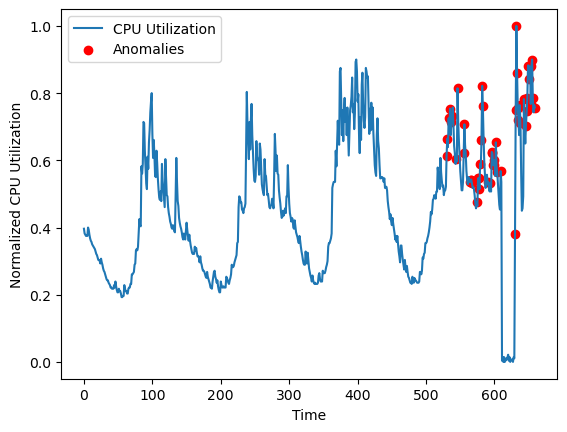

In [10]:
# Optionally, you can plot the CPU utilization data and highlight the anomalies
plt.plot(df2.index, df2['cpu_normalized'], label='CPU Utilization')
plt.scatter(anomalies.index, anomalies['cpu_normalized'], color='red', label='Anomalies')
plt.xlabel('Time')
plt.ylabel('Normalized CPU Utilization')
plt.legend()
plt.show()